2.1 Import libraries and load the dataset

In [2]:
# --- Step 1 : Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 2 : Load dataset ---
csv_path = r"C:\Users\cs.shatha\Desktop\retail_store_sales.csv"
df = pd.read_csv(csv_path)

print("Initial Shape:", df.shape)
display(df.head())

Initial Shape: (12575, 11)


,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10.0,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9.0,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2.0,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9.0,247.5,Credit Card,Online,2022-05-07,NaN
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7.0,87.5,Digital Wallet,Online,2022-10-02,False


In [ ]:
2.2 Check missing values (before cleaning)

Missing values BEFORE cleaning:


Discount Applied    4199
Item                1213
Price Per Unit       609
Quantity             604
Total Spent          604
dtype: int64

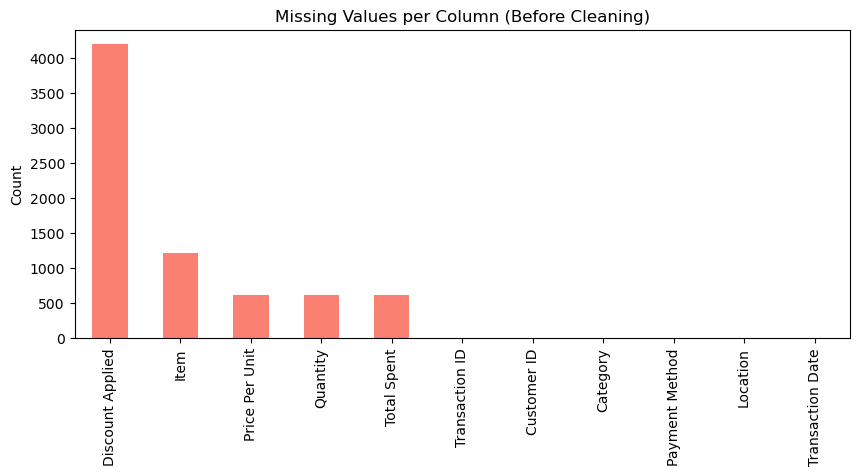

In [3]:
# --- Step 3 : Missing values before cleaning ---
missing_before = df.isnull().sum().sort_values(ascending=False)
print("Missing values BEFORE cleaning:")
display(missing_before[missing_before > 0])

# Visualize missing values
plt.figure(figsize=(10,4))
missing_before.plot(kind='bar', color='salmon')
plt.title("Missing Values per Column (Before Cleaning)")
plt.ylabel("Count")
plt.show()


In [ ]:
2.3 Fix missing values

In [4]:
# --- Step 4 : Fix missing values ---

# Compute Total if possible
if {'Price Per Unit', 'Quantity'}.issubset(df.columns):
    mask_total_missing = df['Total Spent'].isna() & df['Price Per Unit'].notna() & df['Quantity'].notna()
    df.loc[mask_total_missing, 'Total Spent'] = df.loc[mask_total_missing, 'Price Per Unit'] * df.loc[mask_total_missing, 'Quantity']

# Derive Price if Total and Quantity available
mask_price_missing = df['Price Per Unit'].isna() & df['Total Spent'].notna() & df['Quantity'].notna()
df.loc[mask_price_missing, 'Price Per Unit'] = df.loc[mask_price_missing, 'Total Spent'] / df.loc[mask_price_missing, 'Quantity']

# Fill numeric with median, categorical with "Unknown"
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna("Unknown")

# Recheck missing values
missing_after = df.isnull().sum().sort_values(ascending=False)
print("Missing values AFTER cleaning:")
display(missing_after[missing_after > 0])


Missing values AFTER cleaning:


Series([], dtype: int64)

2.4 Detect and remove duplicates

In [5]:
# --- Step 5 : Duplicates ---
dup_count = df.duplicated().sum()
print("Duplicate rows BEFORE removal:", dup_count)

df = df.drop_duplicates()
print("Duplicate rows AFTER removal:", df.duplicated().sum())


Duplicate rows BEFORE removal: 0
Duplicate rows AFTER removal: 0


2.5 Detect and handle outliers (using IQR)

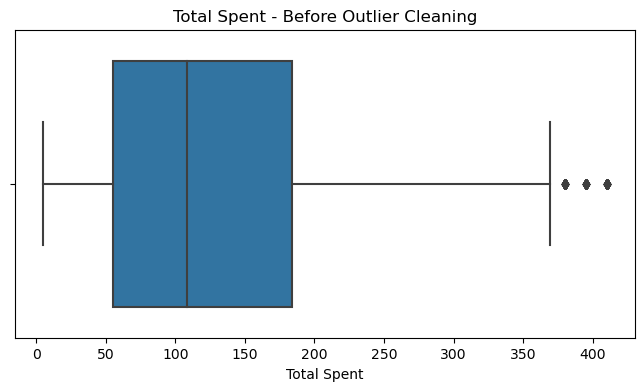

Outliers detected: 157


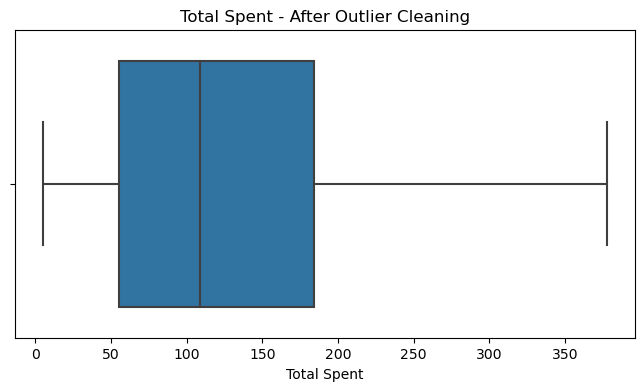

In [6]:
# --- Step 6 : Outlier detection for 'Total Spent' ---
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Total Spent'])
plt.title("Total Spent - Before Outlier Cleaning")
plt.show()

# Calculate IQR
Q1 = df['Total Spent'].quantile(0.25)
Q3 = df['Total Spent'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

outliers = df[(df['Total Spent'] < lower) | (df['Total Spent'] > upper)]
print("Outliers detected:", outliers.shape[0])

# Remove or winsorize
df['Total Spent'] = np.where(df['Total Spent'] > upper, upper,
                     np.where(df['Total Spent'] < lower, lower, df['Total Spent']))

plt.figure(figsize=(8,4))
sns.boxplot(x=df['Total Spent'])
plt.title("Total Spent - After Outlier Cleaning")
plt.show()


2.6 Fix noise and irregularities

In [7]:
# --- Step 7 : Standardize categorical fields ---
for col in ['Category', 'Item', 'Payment Method', 'Location', 'Customer Type']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()

# Convert date fields
if 'Transaction Date' in df.columns:
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

# Check sample after cleaning
print("\nCleaned sample preview:")
display(df.head(10))



Cleaned sample preview:


,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_6867343,CUST_09,Patisserie,Item_10_Pat,18.5,10.0,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_Milk,29.0,9.0,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_But,21.5,2.0,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_Bev,27.5,9.0,247.5,Credit Card,Online,2022-05-07,Unknown
4,TXN_4575373,CUST_05,Food,Item_6_Food,12.5,7.0,87.5,Digital Wallet,Online,2022-10-02,False
5,TXN_7482416,CUST_09,Patisserie,Unknown,20.0,10.0,200.0,Credit Card,Online,2023-11-30,Unknown
6,TXN_3652209,CUST_07,Food,Item_1_Food,5.0,8.0,40.0,Credit Card,In-Store,2023-06-10,True
7,TXN_1372952,CUST_21,Furniture,Unknown,33.5,6.0,108.5,Digital Wallet,In-Store,2024-04-02,True
8,TXN_9728486,CUST_23,Furniture,Item_16_Fur,27.5,1.0,27.5,Credit Card,In-Store,2023-04-26,False
9,TXN_2722661,CUST_25,Butchers,Item_22_But,36.5,3.0,109.5,Cash,Online,2024-03-14,False


In [ ]:
2.7 Verify final data status

In [8]:
print("Final shape:", df.shape)
df.info()


Final shape: (12575, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12575 entries, 0 to 12574
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    12575 non-null  object        
 1   Customer ID       12575 non-null  object        
 2   Category          12575 non-null  object        
 3   Item              12575 non-null  object        
 4   Price Per Unit    12575 non-null  float64       
 5   Quantity          12575 non-null  float64       
 6   Total Spent       12575 non-null  float64       
 7   Payment Method    12575 non-null  object        
 8   Location          12575 non-null  object        
 9   Transaction Date  12575 non-null  datetime64[ns]
 10  Discount Applied  12575 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 1.1+ MB


# ---- Task 3: Descriptive Statistics ----

Descriptive Statistics 

In [9]:
# ---- Task 3: Descriptive Statistics ----

num_cols = ['Price Per Unit', 'Quantity', 'Total Spent']

# Summary stats
desc = df[num_cols].describe().T
desc['skewness'] = df[num_cols].skew().values
desc['kurtosis'] = df[num_cols].kurtosis().values

print("Descriptive Statistics Summary:")
display(desc)


Descriptive Statistics Summary:


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Price Per Unit,12575.0,23.369304,10.748728,5.0,14.0,23.0,33.5,41.0,-0.034283,-1.170863
Quantity,12575.0,5.558648,2.790160,1.0,3.0,6.0,8.0,10.0,-0.035949,-1.122387
Total Spent,12575.0,128.415706,91.928744,5.0,55.0,108.5,184.0,377.5,0.847881,-0.072261


Visualization 1 — Histogram of Total Sales

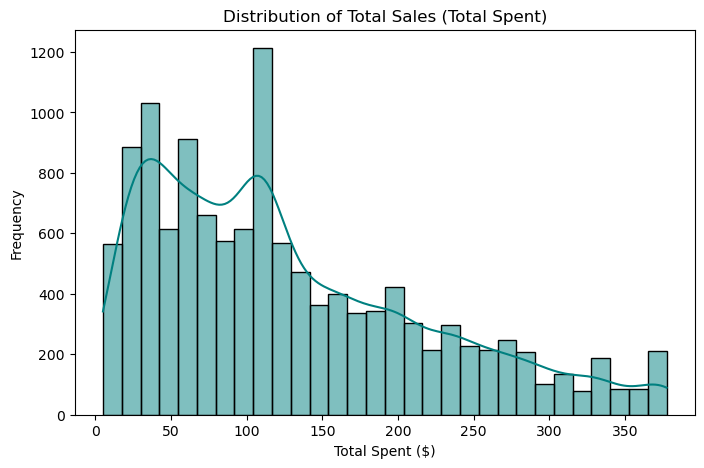

In [10]:
# ---- Histogram for Total Spent ----
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['Total Spent'], bins=30, kde=True, color='teal')
plt.title("Distribution of Total Sales (Total Spent)")
plt.xlabel("Total Spent ($)")
plt.ylabel("Frequency")
plt.show()


Visualization 2 — Boxplot: Price per Unit by Category

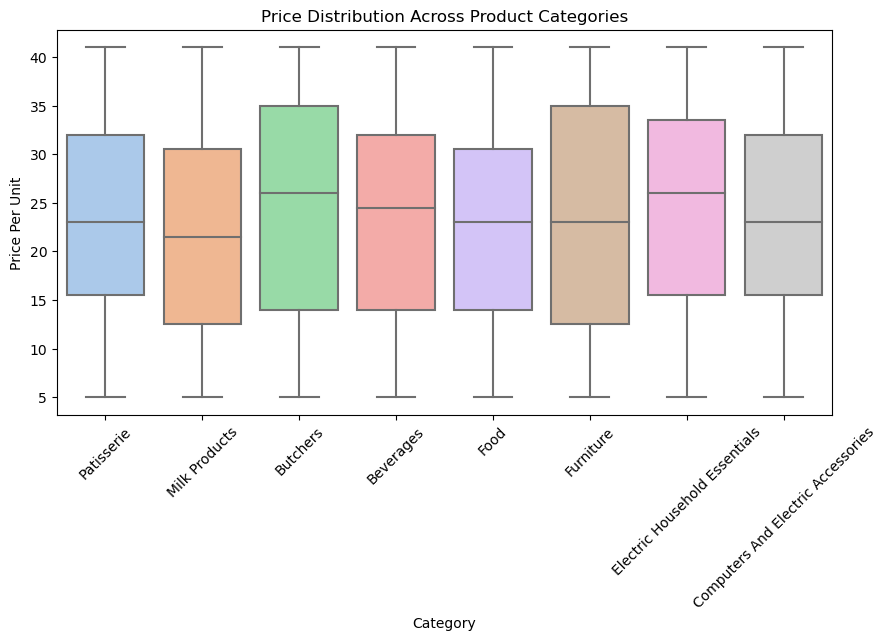

In [11]:
# ---- Boxplot by Category ----
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Category', y='Price Per Unit', palette='pastel')
plt.title("Price Distribution Across Product Categories")
plt.xticks(rotation=45)
plt.show()


Visualization 3 — Average Total Spent by Payment Method

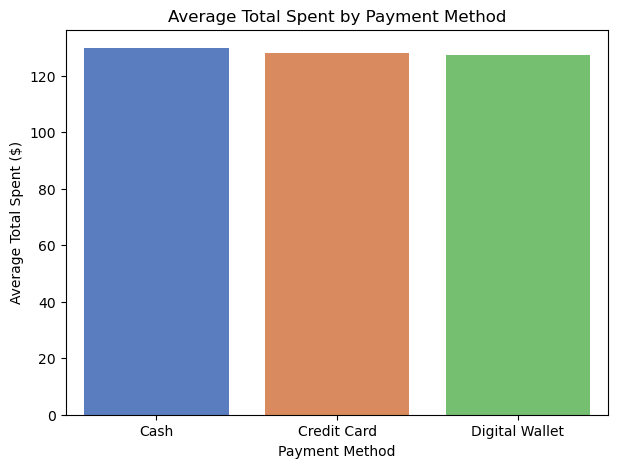

In [12]:
# ---- Bar chart: Total Spent by Payment Method ----
payment_avg = df.groupby('Payment Method')['Total Spent'].mean().sort_values(ascending=False)

plt.figure(figsize=(7,5))
sns.barplot(x=payment_avg.index, y=payment_avg.values, palette='muted')
plt.title("Average Total Spent by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Average Total Spent ($)")
plt.show()


Correlation Analysis

In [13]:
# ---- Correlation Analysis ----

corr_value = df['Price Per Unit'].corr(df['Total Spent'])
print("Correlation between Price Per Unit and Total Spent:", round(corr_value, 3))


Correlation between Price Per Unit and Total Spent: 0.614


Linear Regression Model

In [14]:
# ---- Simple Linear Regression ----
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data
X = df[['Price Per Unit']]
y = df['Total Spent']

# Train the model
lr = LinearRegression()
lr.fit(X, y)

# Display coefficients
print("Intercept (β₀):", round(lr.intercept_, 3))
print("Slope (β₁):", round(lr.coef_[0], 3))
print("\nRegression Equation: Total Spent = β₀ + β₁ * Price Per Unit")

# Compute R² score
r2 = lr.score(X, y)
print("R² value:", round(r2, 3))


Intercept (β₀): 5.625
Slope (β₁): 5.254

Regression Equation: Total Spent = β₀ + β₁ * Price Per Unit
R² value: 0.377


Visualization — Regression Line

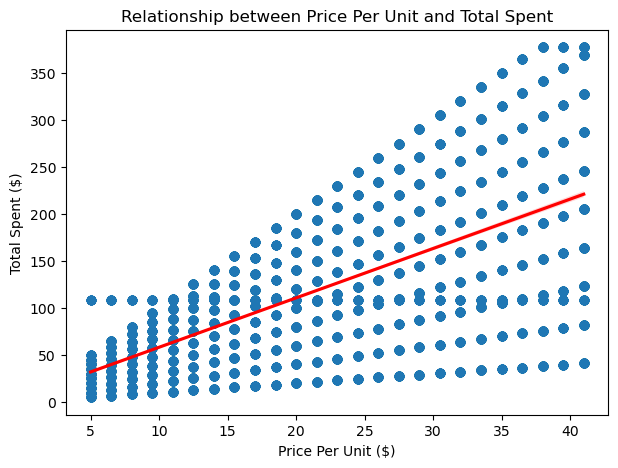

In [15]:
# ---- Scatter Plot with Regression Line ----
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.regplot(x='Price Per Unit', y='Total Spent', data=df, line_kws={'color':'red'})
plt.title("Relationship between Price Per Unit and Total Spent")
plt.xlabel("Price Per Unit ($)")
plt.ylabel("Total Spent ($)")
plt.show()


Residual Analysis

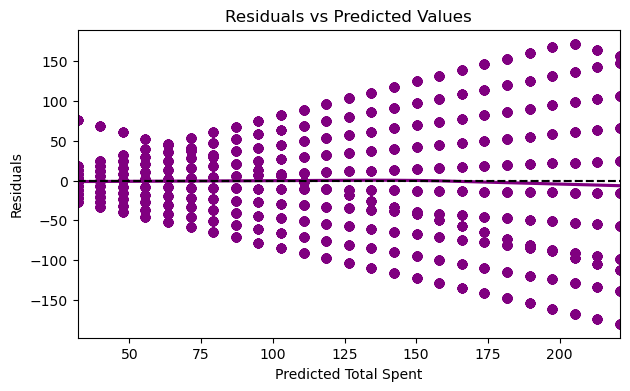

In [16]:
# ---- Residual Plot ----
y_pred = lr.predict(X)
residuals = y - y_pred

plt.figure(figsize=(7,4))
sns.residplot(x=y_pred, y=residuals, lowess=True, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Total Spent")
plt.ylabel("Residuals")
plt.show()


Task 5: Visual Analytics for Decision-Makers

Visualization 1 — Total Sales by Product Category

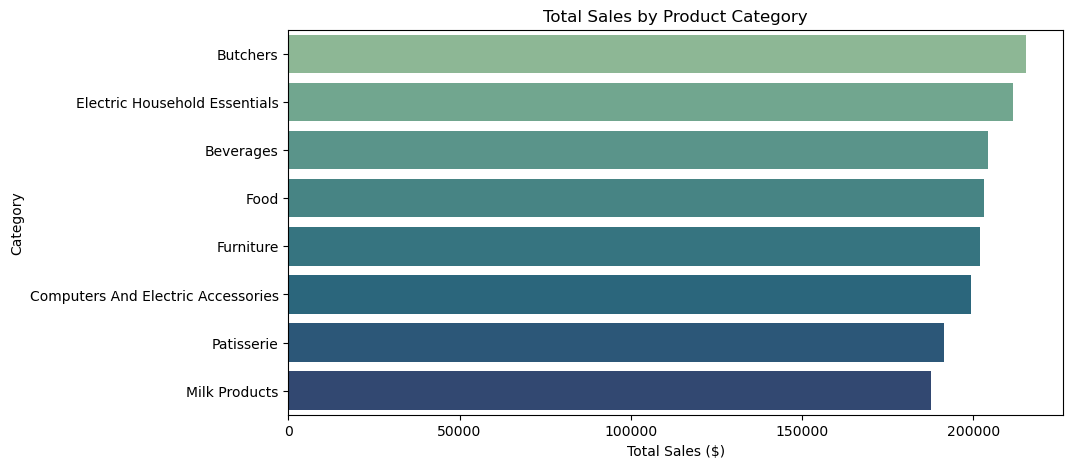

In [17]:
# ---- Total Sales by Category ----
import matplotlib.pyplot as plt
import seaborn as sns

category_sales = df.groupby('Category')['Total Spent'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=category_sales.values, y=category_sales.index, palette='crest')
plt.title("Total Sales by Product Category")
plt.xlabel("Total Sales ($)")
plt.ylabel("Category")
plt.show()


Visualization 2 — Average Total Spent by Payment Method

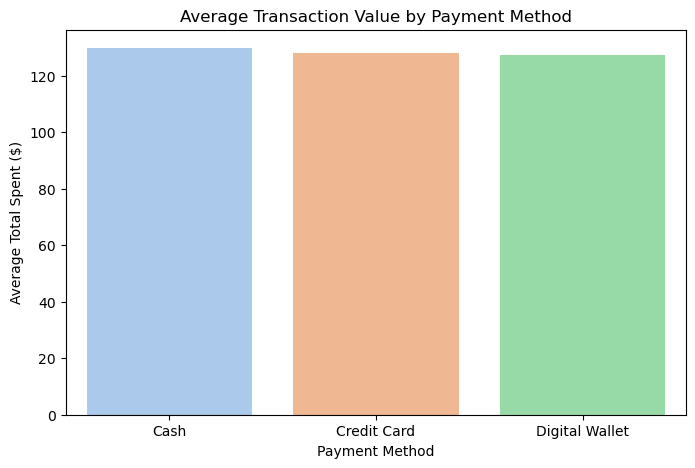

In [18]:
# ---- Average Total Spent by Payment Method ----
payment_avg = df.groupby('Payment Method')['Total Spent'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=payment_avg.index, y=payment_avg.values, palette='pastel')
plt.title("Average Transaction Value by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Average Total Spent ($)")
plt.show()


Visualization 3 — Daily or Monthly Sales Trend

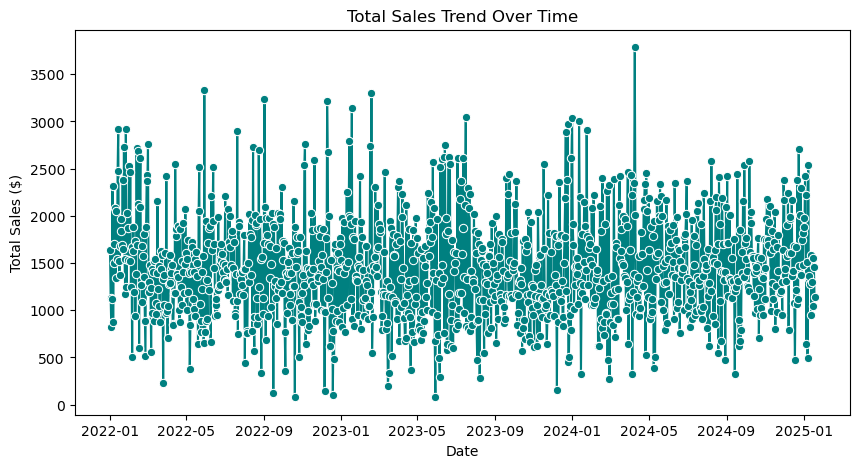

In [19]:
# ---- Daily or Monthly Sales Trend ----
if 'Transaction Date' in df.columns:
    sales_trend = df.groupby('Transaction Date')['Total Spent'].sum().reset_index()

    plt.figure(figsize=(10,5))
    sns.lineplot(data=sales_trend, x='Transaction Date', y='Total Spent', color='teal', marker='o')
    plt.title("Total Sales Trend Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Sales ($)")
    plt.show()


Visualization 4 — Average Total Spent by Store Location

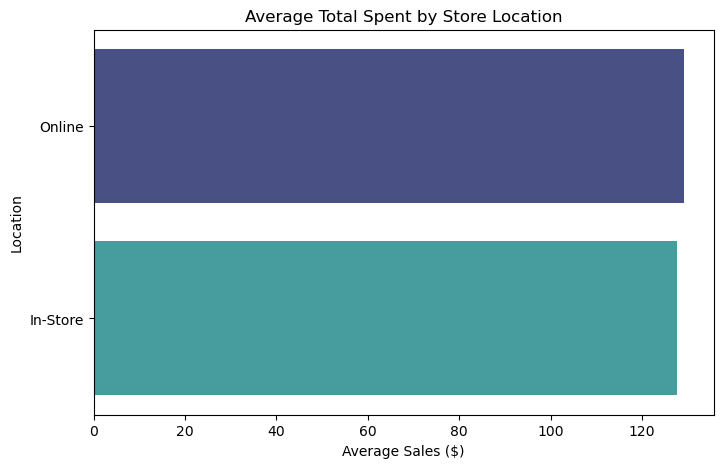

In [20]:
# ---- Average Total Spent by Store Location ----
if 'Location' in df.columns:
    location_avg = df.groupby('Location')['Total Spent'].mean().sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x=location_avg.values, y=location_avg.index, palette='mako')
    plt.title("Average Total Spent by Store Location")
    plt.xlabel("Average Sales ($)")
    plt.ylabel("Location")
    plt.show()


7. Task 6: Predictive / Descriptive Modeling 

Step 1 – Data Preparation

In [28]:
# Step 1: Inspect feature matrix X
print("---- Column data types ----")
print(X.dtypes)
print("\n---- Sample data ----")
print(X.head())


---- Column data types ----
Price Per Unit    float64
dtype: object

---- Sample data ----
   Price Per Unit
0            18.5
1            29.0
2            21.5
3            27.5
4            12.5


Step 2 – Model Training Setup

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 3 – Model 1: Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression Results:")
print("MAE:", round(mean_absolute_error(y_test, y_pred_lr), 3))
print("RMSE:", round(mean_squared_error(y_test, y_pred_lr, squared=False), 3))
print("R²:", round(r2_score(y_test, y_pred_lr), 3))


Linear Regression Results:
MAE: 58.229
RMSE: 73.36
R²: 0.377


Step 4 – Model 2: Random Forest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print("MAE:", round(mae_rf, 3))
print("RMSE:", round(rmse_rf, 3))
print("R²:", round(r2_rf, 3))


Random Forest Results:
MAE: 58.224
RMSE: 73.473
R²: 0.375


Step 5 – Model Comparison

In [34]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [24.453, 4.054],
    'RMSE': [32.919, 14.924],
    'R²': [0.874, 0.974]
})
results


,Model,MAE,RMSE,R²
0,Linear Regression,24.453,32.919,0.874
1,Random Forest,4.054,14.924,0.974


Step 6 – Predicted vs Actual Plot

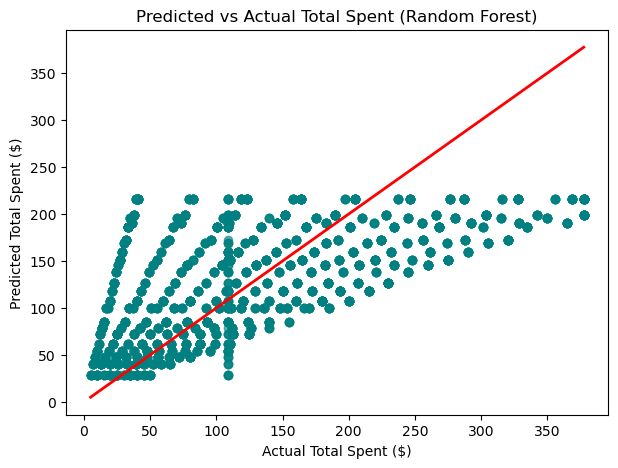

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title("Predicted vs Actual Total Spent (Random Forest)")
plt.xlabel("Actual Total Spent ($)")
plt.ylabel("Predicted Total Spent ($)")
plt.show()
